
# Reconnaissance faciale via un réseau de neuron 

## Partie 2: Reconnaissance faciale en temps réel (classification binaire "admis"/"non-admis")

## Librairies

In [9]:
import pickle
import numpy as np
import cv2 
from tensorflow import keras
from tensorflow.keras.models import Model
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras import layers

### Choix du type de classification (binaire via admis/non-admis ou multiclasses via les noms)


In [10]:
choix_classification = 1 # Binaire
#choix_classification = 0 # Multiclass

## Algorithme

In [11]:
# Variable vers le dataset
DATASET = "../dataset/data/"
DATASET_BINAIRE = "../dataset/data_binary_classification/"

if choix_classification == 1:
        

    with open(DATASET_BINAIRE+'/targets.pkl', 'rb') as fh:
        targets = pickle.load(fh)
        targets = np.array(targets)

    with open(DATASET_BINAIRE+'/features.pkl', 'rb') as fh:
        features = pickle.load(fh)
        features = np.array(features)

    print('Shape of visages matrix --> ', features.shape)
elif choix_classification == 0:
    

    with open(DATASET+'/visages.pkl', 'rb') as fh:
        features = pickle.load(fh)
        features = np.array(features)

    with open(DATASET+'/noms.pkl', 'rb') as fh:
        targets = pickle.load(fh)
print('Shape of visages matrix --> ', features.shape)

Shape of visages matrix -->  (200, 50, 50, 3)
Shape of visages matrix -->  (200, 50, 50, 3)


## Qu'est-ce qu'un réseau de neurones convolutifs ?

Les réseaux de neurones convolutifs (CNN) sont une classe spécifique de réseaux de neurones profonds, conçus principalement pour traiter des données structurées en grille telles que des images. Ils se distinguent des réseaux de neurones multicouches (MLP) par leur capacité à exploiter la structure spatiale des données d'entrée c'est à dire mettre le focus sur les régions importante d'une images par exemple. Le but d'un CCN est de trouver les caractéristiques les plus marquantes d'une images afin de donner une prédictions qui s'approche le plus possible de la réalité. 

### Comment le réseau apprend à reconnaitre les caractéristiques clé d'une image 


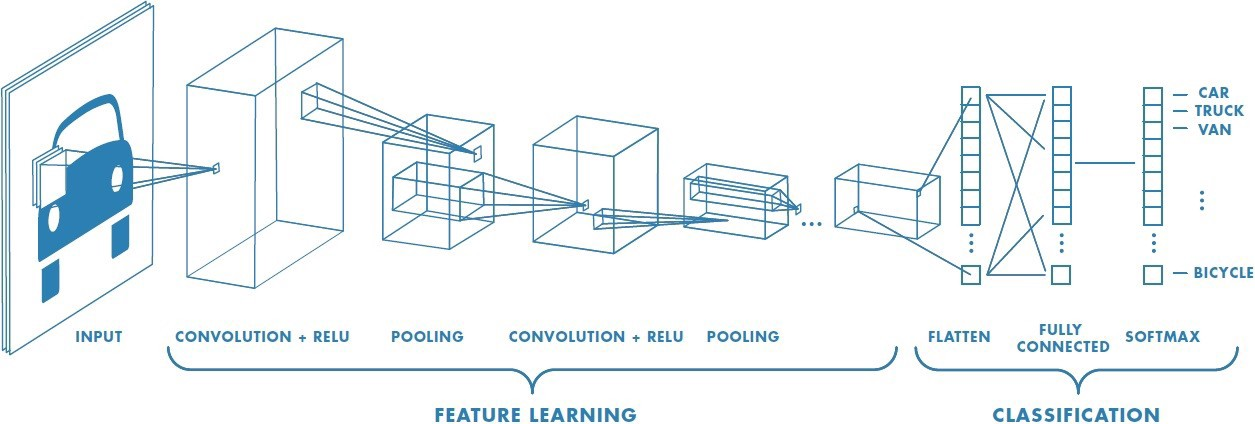

__La figure montre le flux complet d'informations dans une architecture CNN pour traiter une image d'entrée et la classer sur la base de valeurs__

Passons en revue chacune des étapes 

### La Convolution 
 Elle consiste à appliquer un filtre (noyau ou encore kernel) à une petite région de l'image d'entrée à la fois, déplaçant ce filtre sur toute l'image pour extraire des caractéristiques locales.


[[-10   0  10]
 [-10   0  10]
 [-10   0  10]]


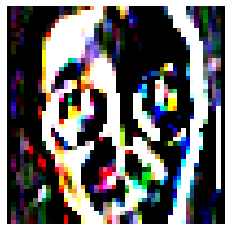

In [12]:
# Exemple d'un kernel de convolution qui detecte les contours verticaux
sample = features[0]
kernel = np.matrix([[-10,0,10],[-10,0,10],[-10,0,10]])
print(kernel)
img_1 = cv2.filter2D(sample, -1, kernel)
plt.axis('off')
plt.imshow(cv2.cvtColor(img_1, cv2.COLOR_BGR2RGB))

[[-10 -10 -10]
 [  0   0   0]
 [ 10  10  10]]


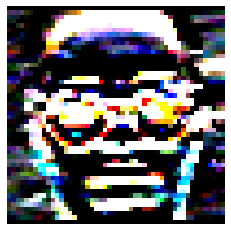

In [13]:
# Exemple d'un kernel de convolution qui detecte les contours horizontaux
sample = features[0]
kernel = np.matrix([[-10,-10,-10],[0,0,0],[10,10,10]])
print(kernel)
img_2 = cv2.filter2D(sample, -1, kernel)
plt.axis('off')
plt.imshow(cv2.cvtColor(img_2, cv2.COLOR_BGR2RGB))

La Convolution est en réalité un opération mathématique, elle représente dans notre cas (et d'après ce que j'ai compris) le produit entre deux matrice, la matrice qui représente l'image et celle qui représente le filtre. On va plus précisement réaliser succéssivement, le produit du dernier élément de la matrice image avec le premier, auquel on ajoute le second par l'avant dernier puis ainsi de suite. 

On peut modéliser cela par l'équation suivante :
Soit deux matrice $x$ et $y$ avec $m$ lignes et $n$ colonnes.

On a : 


$$
\begin{bmatrix}
x_{11} & x_{12} & \cdots & x_{1n} \\
x_{21} & x_{22} & \cdots & x_{2n} \\
\vdots & \vdots & \ddots & \vdots \\
x_{m1}  &  x_{m2} & \cdots & x_{mn}
\end{bmatrix}
*
\begin{bmatrix}
y_{11} & x_{12} & \cdots & y_{1n} \\
y_{21} & x_{22} & \cdots & y_{2n} \\
\vdots & \vdots & \ddots & \vdots \\
y_{m1}  &  y_{m2} & \cdots & y_{mn}
\end{bmatrix}
=
\sum^{m-1}_{i=0} \sum^{n-1}_{j=0}x_{(m-i)(n-j)}y_{(1+i)(1+j)}
$$

In [14]:
#example
from scipy.ndimage import convolve
m = [[10, 10, 1],[10, 1, 1],[-10, 1, 1]]
k = [[10, 10, 10],[0, 0, 0],[-10, -10, -10]]

c= convolve(m, k , mode='constant', cval=0.0)
print('Matrix')
print('\n'.join([''.join(['{:4}'.format(item) for item in row]) 
      for row in m]))

print('Kernel')
print('\n'.join([''.join(['{:4}'.format(item) for item in row]) 
      for row in k]))

print('Convolution')
print('\n'.join([''.join(['{:4}'.format(item) for item in row]) 
      for row in c]))


Matrix
  10  10   1
  10   1   1
 -10   1   1
Kernel
  10  10  10
   0   0   0
 -10 -10 -10
Convolution
 110 120  20
-290-290 -90
-110-120 -20


On pourrait interpréter les valeurs élevées comme suit :

    Les valeurs positives (110, 120, 20) pourraient indiquer des zones où il y a une transition d'intensité croissante. Cela pourrait correspondre à des bords ou des contours dans l'image d'origine.

    Les valeurs négatives (-290, -290, -90) pourraient indiquer des zones où il y a une transition d'intensité décroissante. Ces zones pourraient également être associées à des caractéristiques spécifiques de l'image.

## Pooling (ou sous-échantillonnage) :
    
Le pooling est un autre concept clé dans notre quête d'obtenir le meilleur kernel, il s'agit une opération couramment utilisée pour réduire la dimension spatiale d'une représentation d'image. Il existe deux types courants de pooling : le max pooling et la moyenne pooling.

- Max pooling : Consiste à diviser l'image en régions disjointes et à sélectionner la valeur maximale de chaque région. Cela permet de conserver les caractéristiques les plus importantes de chaque région, tout en réduisant la dimension de l'image. (Ce que j'ai choisis de faire dans mon cas)

- Moyenne pooling : Il fonctionne de manière similaire, mais au lieu de sélectionner la valeur maximale, il prend la moyenne des valeurs de chaque région.

L'objectif du pooling est de réduire la taille de la représentation tout en préservant les informations importantes.

### Le Pooling en image 
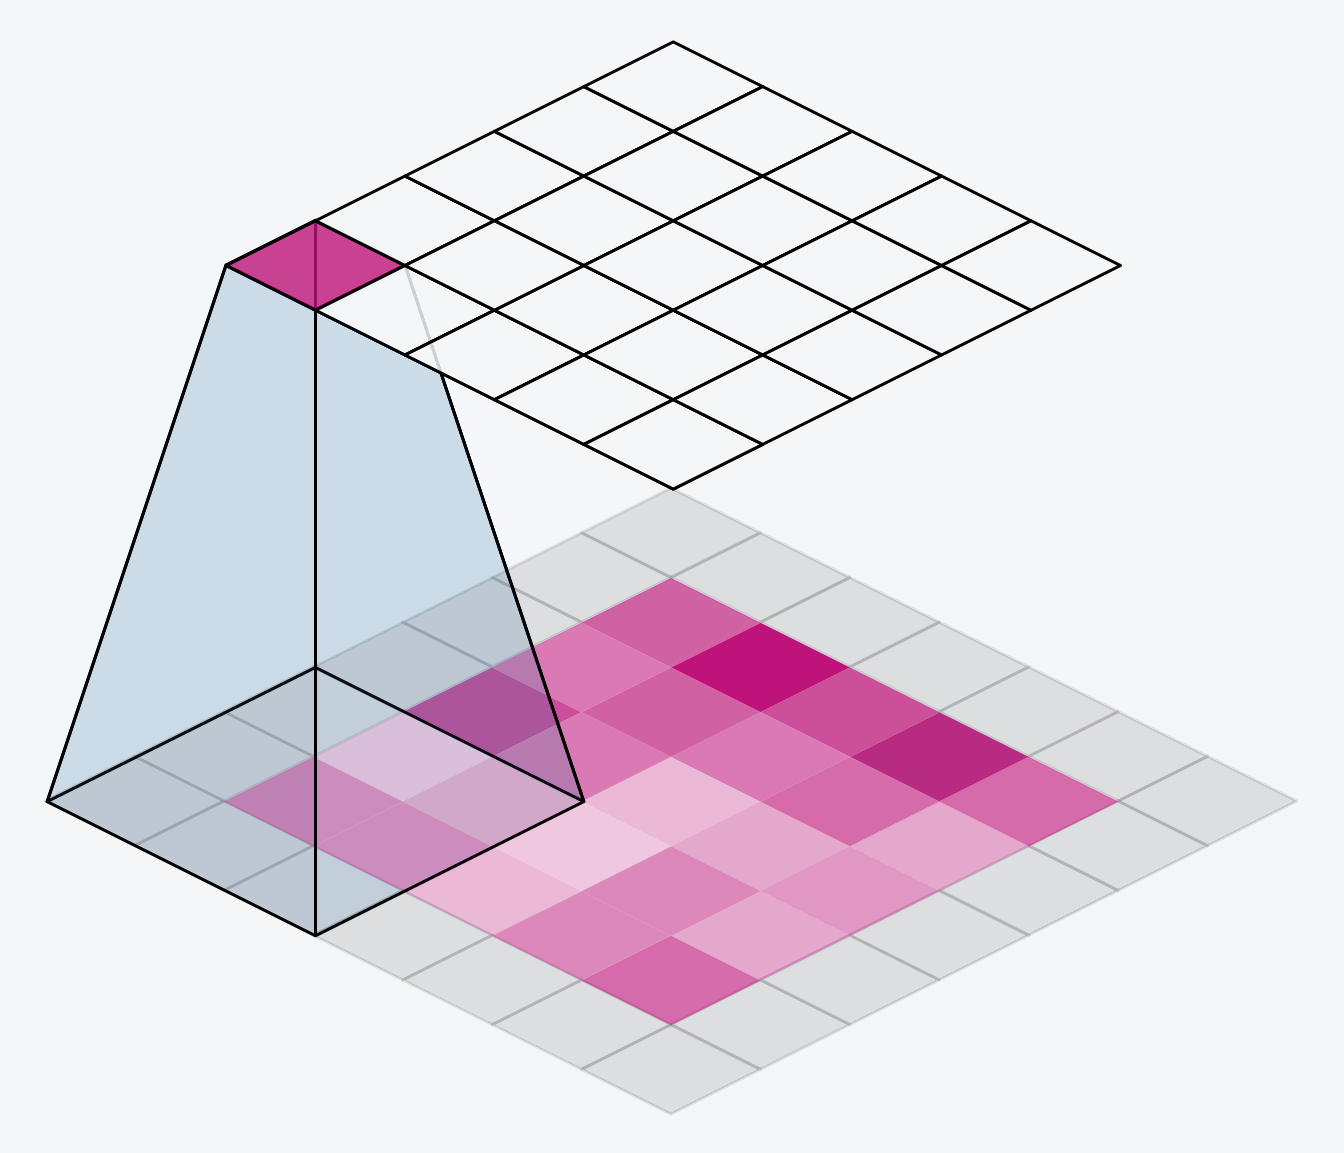
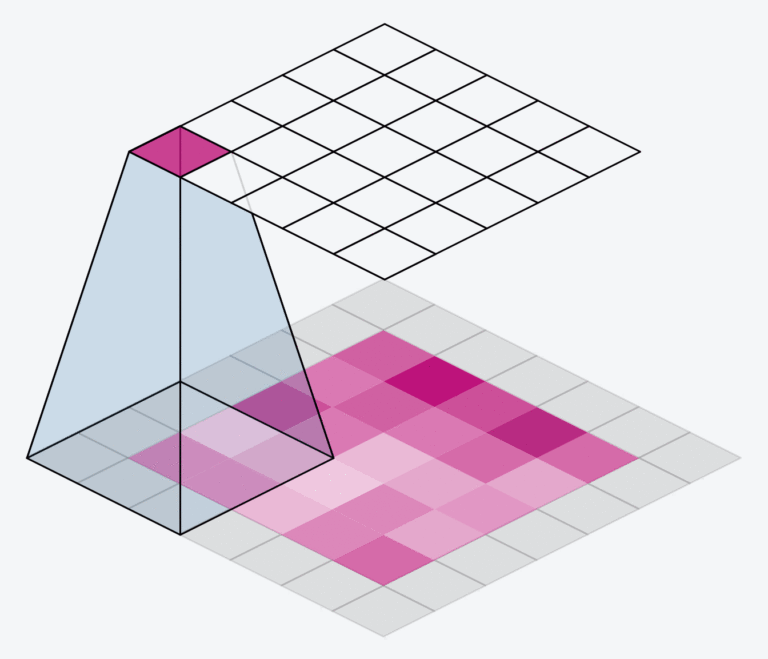

En réalité, là aussi se sont des mathématique qui se trouvent derrière, voici un schéma pour illustrer comment le "pooling" permet de d'extraire les parties importante de l'image


![0 uYmuSGuwM7N-88QT.gif](<attachment:0 uYmuSGuwM7N-88QT.gif>)

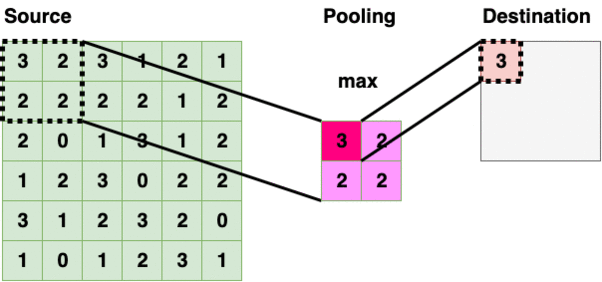

La convolution et le pooling sont des opérations que l'on répète au fur et à mesure, le kernel s'affine jusqu'a ne retourner "que l'essentiel"

Une fois la convolution et le pooling réalisés, on peut utiliser une couche de "flatten" concrètement, cette va faire la transition de nos itérations de convolution et de pooling vers une réseau de neurons. Dans notre cas, chacune des couches du réseau est connectée à chaque neurone de la couche précédente : on appel se type de réseaux un Dense Layer.

Toutes sont alors à mettre en pratique dans le cadre de l'apprentissage

Epoch 1/40


16/16 [==============================] - 5s 67ms/step - loss: 0.5676 - accuracy: 0.6687 - val_loss: 0.7334 - val_accuracy: 0.1250
Epoch 2/40
16/16 [==============================] - 1s 32ms/step - loss: 0.1917 - accuracy: 0.9500 - val_loss: 0.0362 - val_accuracy: 1.0000
Epoch 3/40
16/16 [==============================] - 0s 31ms/step - loss: 0.0299 - accuracy: 0.9875 - val_loss: 0.0045 - val_accuracy: 1.0000
Epoch 4/40
16/16 [==============================] - 1s 37ms/step - loss: 0.0451 - accuracy: 0.9750 - val_loss: 0.0036 - val_accuracy: 1.0000
Epoch 5/40
16/16 [==============================] - 0s 26ms/step - loss: 0.0120 - accuracy: 0.9937 - val_loss: 0.0074 - val_accuracy: 1.0000
Epoch 6/40
16/16 [==============================] - 0s 31ms/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 0.0045 - val_accuracy: 1.0000
Epoch 7/40
16/16 [==============================] - 0s 30ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.0023 - val_accuracy: 1.0000
Epoch 8/40
16/16 [======

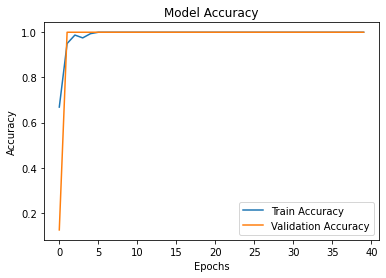

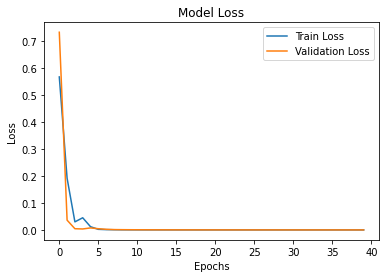

In [15]:
N = len(targets) # Nombre d'images
features = features.reshape(N, 50, 50, 3)   # Redimensionnement des images
input_shape = (50, 50, 3)  # Taille des images
features = features / 255.0 # Normalisation des images

# Modèle CNN
model = keras.Sequential([ # Création d'un modèle séquentiel (où l'on va empiler les couches les unes sur les autres)
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape), # Ajout d'une couche de convolution avec 32 filtres de taille 3x3
    layers.MaxPooling2D((2, 2)), # Ajout d'une couche de pooling
    layers.Conv2D(64, (3, 3), activation='relu'), # Ajout d'une couche de convolution avec 64 filtres de taille 3x3
    layers.MaxPooling2D((2, 2)), # Ajout d'une couche de pooling
    layers.Conv2D(128, (3, 3), activation='relu'), # ... convolution
    layers.MaxPooling2D((2, 2)), # ... pooling
    layers.Flatten(), # Aplatir les données, pour les passer à travers des couches denses (réseaux de neurones classiques et complètement connectés)
    layers.Dense(128, activation='relu'), # Ajout d'une couche dense avec 128 neurones
    layers.Dense(1, activation='sigmoid')  # Ajout d'une couche dense avec 1 neurone (car on veut une prédiction binaire)
])

model.compile(optimizer='adam', # Optimiseur
              loss='binary_crossentropy', # Fonction de perte
              metrics=['accuracy']) # Métrique d'évaluation

# Entraînement du modèle
batch_size = 10 # Taille des mini-lots (nombre d'images à passer à travers le réseau à chaque itération)
epochs = 40 # Nombre d'itérations sur l'ensemble des données (nombre de fois où l'on va passer l'ensemble des données à travers le réseau)

history = model.fit(features, targets, batch_size=batch_size, epochs=epochs, validation_split=0.2 ) # Entraînement du modèle (en utilisant 20% des données pour la validation

# Tracé de l'historique
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Exécution

In [16]:
cascade_visage = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

camera = cv2.VideoCapture(0)
authentifications = []
while True:
    
    ret, frame = camera.read()
    
    if ret:
        
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        face_coordinates = cascade_visage.detectMultiScale(gray, 1.3, 5)

        for (x, y, w, h) in face_coordinates:
            
            face = frame[y:y + h, x:x + w, :]
            face_resized = cv2.resize(face, (50, 50)).reshape(1, 50, 50, 3) / 255.0
            
            prediction = model.predict(face_resized)

            if prediction[0][0] <= 0.5:
                authentifications.append(0)
                text = 'Non Admis'
                cv2.putText(frame, text, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
                cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 0, 255), 2)
            else:
                text = 'Admis'
                authentifications.append(1)
                cv2.putText(frame, text, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
                cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
            
        cv2.imshow('La vrais reconnaissance facial', frame)
        
        if cv2.waitKey(1) == 27 or len(authentifications) >= 100:
            cv2.destroyAllWindows()
            camera.release()
            break


if sum(authentifications) / len(authentifications) > 0.8: # Si plus de 80% des résultats sont positifs, on renvoie un token d'authentification OK
    print({"token": True})
else:
    print({"token": False}) # Sinon, on renvoie un token d'authentification NOK



1/1 [==============================] - 0s 45ms/step
{'token': True}


## Sauvegarde pour les performances et authentification

In [17]:
import os
if not os.path.exists('models'):
    os.makedirs('models')
model.save('models/model.keras') # Sauvegarde du modèle
